<a href="https://colab.research.google.com/github/AlvaroJustus/COVID-19/blob/master/COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports & Libraries

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import plotly.express as px
import folium

In [0]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

## Preprocessing & Derive Tables

In [0]:
keys = confirmed_df.keys()
confirmed = confirmed_df.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
deaths = deaths_df.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
recoveries = recoveries_df.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)

In [0]:
dates = keys.drop(['Province/State', 'Country/Region', 'Lat', 'Long'])

In [0]:
deaths_rates = pd.DataFrame(deaths.sum()/confirmed.sum())
deaths_rates.rename(columns={0:'Mortality Rate'},inplace=True)
recoveries_rates = pd.DataFrame(recoveries.sum()/confirmed.sum())
recoveries_rates.rename(columns={0:'Recovery Rate'},inplace=True)

In [0]:
world_cases = confirmed.sum()
world_deaths = deaths.sum()
world_recoveries = recoveries.sum()
days_1_22 = pd.DataFrame(np.array([i for i in range(len(confirmed.keys()))]).reshape(-1, 1))
br_cases = confirmed[confirmed_df['Country/Region'] == 'Brazil']
it_cases = confirmed[confirmed_df['Country/Region'] == 'Italy']
ch_cases = confirmed[confirmed_df['Country/Region'] == 'China']
us_cases = confirmed[confirmed_df['Country/Region'] == 'US']
sa_cases = confirmed[confirmed_df['Country/Region'] == 'South Africa']
es_cases = confirmed[confirmed_df['Country/Region'] == 'Spain']

In [0]:
LatLong = pd.DataFrame((confirmed_df.groupby(['Country/Region']).sum()).iloc[:,0:2]).reset_index()
latest_confirmed = pd.DataFrame((confirmed_df.groupby(['Country/Region']).sum()).iloc[:,-1]).reset_index()
latest_confirmed.rename(columns= {"Country/Region":"Country/Region",latest_confirmed.keys()[-1]: "Confirmed"},inplace=True)
latest_recoveries = pd.DataFrame((recoveries_df.groupby(['Country/Region']).sum()).iloc[:,-1]).reset_index()
latest_recoveries.rename(columns= {"Country/Region":"Country/Region",latest_recoveries.keys()[-1]: "Recovered"},inplace=True)
latest_deaths = pd.DataFrame((deaths_df.groupby(['Country/Region']).sum()).iloc[:,-1]).reset_index()
latest_deaths.rename(columns= {"Country/Region":"Country/Region",latest_deaths.keys()[-1]: "Deaths"},inplace=True)

In [0]:
By_Countries = pd.concat([latest_confirmed,latest_recoveries,latest_deaths], axis=1)
By_Countries2 = pd.concat([LatLong,latest_confirmed,latest_recoveries,latest_deaths], axis=1)
By_Countries = By_Countries.loc[:,~By_Countries.columns.duplicated()]
By_Countries['Active'] = By_Countries['Confirmed'] - By_Countries['Deaths'] - By_Countries['Recovered']
By_Countries2 = By_Countries2.loc[:,~By_Countries2.columns.duplicated()]
By_Countries2['Active'] = By_Countries['Confirmed'] - By_Countries['Deaths'] - By_Countries['Recovered']
By_Countries2['Mortality Rate'] = (By_Countries['Deaths']/By_Countries['Confirmed'])*100
By_Countries2['Recovery Rate'] = (By_Countries['Recovered']/By_Countries['Confirmed'])*100
By_Countries = By_Countries.sort_values(by='Confirmed', ascending=False)
By_Dates = pd.concat([world_cases, world_recoveries, world_deaths], axis=1).reset_index()
By_Dates.rename(columns= {"index": "Date", 0: "Confirmed", 1: "Recovered",2:"Deaths"}, inplace= True)
By_Dates['Active'] = By_Dates['Confirmed'] - By_Dates['Deaths'] - By_Dates['Recovered']

## Data Visualization & Predict

In [88]:
By_Countries.style.background_gradient(cmap="Blues", subset=['Confirmed'])\
            .background_gradient(cmap="Greens", subset=['Recovered'])\
            .background_gradient(cmap="Oranges", subset=['Active'])\
            .background_gradient(cmap="Reds", subset=['Deaths'])

,Country/Region,Confirmed,Recovered,Deaths,Active
168,US,188172,7024,3873,177275
84,Italy,105792,15729,12428,77635
153,Spain,95923,19259,8464,68200
36,China,82279,76206,3309,2764
65,Germany,71808,16100,775,54933
61,France,52827,9513,3532,39782
80,Iran,44605,14656,2898,27051
172,United Kingdom,25481,179,1793,23509
158,Switzerland,16605,1823,433,14349
167,Turkey,13531,243,214,13074


In [89]:
map = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=4, zoom_start=1)

for i in range(0, len(By_Countries2)):
    folium.Circle(
        location=[By_Countries2.iloc[i]['Lat'], By_Countries2.iloc[i]['Long']],
        color='crimson', 
        tooltip =   '<li><bold>Country : '+str(By_Countries2.iloc[i]['Country/Region'])+
                    '<li><bold>Confirmed : '+str(By_Countries2.iloc[i]['Confirmed'])+
                    '<li><bold>Active : '+str(By_Countries2.iloc[i]['Active'])+
                    '<li><bold>Recovered : '+str(By_Countries2.iloc[i]['Recovered'])+
                    '<li><bold>Deaths : '+str(By_Countries2.iloc[i]['Deaths']),
        radius=int(By_Countries2.iloc[i]['Confirmed'])**1.1).add_to(map)
map
#map.save('map.html')

In [0]:
future_days = 10
future = pd.DataFrame(np.array([i for i in range(len(confirmed.keys())+future_days)]).reshape(-1, 1))
adjusted_dates = pd.DataFrame(future[:-10])

In [0]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [92]:
obj = By_Dates
obj = obj.melt(id_vars="Date", value_vars=['Recovered', 'Deaths', 'Active'],
                 var_name='Status', value_name='Count')
obj.head()

fig = px.area(obj, x="Date", y="Count", color='Status', height=800,
             title='Cases over time', color_discrete_sequence = ['#21bf73', '#ff2e63', '#fe9801'])
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

In [0]:
MR = By_Countries2[By_Countries2['Confirmed']> 100]
MR = MR.sort_values('Mortality Rate', ascending= True)
MR['Mortality Rate'] = MR['Mortality Rate'].round(2)
RR = By_Countries2[By_Countries2['Confirmed']> 100]
RR = RR[RR['Recovered']> 100]
RR = RR.sort_values('Recovery Rate', ascending = True)
RR.drop(47, inplace= True)
RR['Recovery Rate'] = RR['Recovery Rate'].round(2)

In [94]:
fig1 = px.bar(MR.tail(10), x="Mortality Rate", y="Country/Region", text='Mortality Rate', orientation='h')
fig1.update_traces(marker_color='#9F0000', opacity=0.8, textposition='auto')
fig1

In [95]:
fig2 = px.bar(RR.tail(10), x="Recovery Rate", y="Country/Region", text='Recovery Rate', orientation='h')
fig2.update_traces(marker_color='#00FF7F', opacity=0.8, textposition='auto')
fig2

In [96]:
fig = px.pie(By_Countries2.sort_values(by='Deaths', ascending= False).reset_index(drop=True).head(15),
       names = "Country/Region",
       values = 'Deaths', height=750,
       title='Number of Deaths Reported',
       color_discrete_sequence = px.colors.qualitative.Prism)
fig.data[0].textinfo = 'label+text+value'
fig.show()

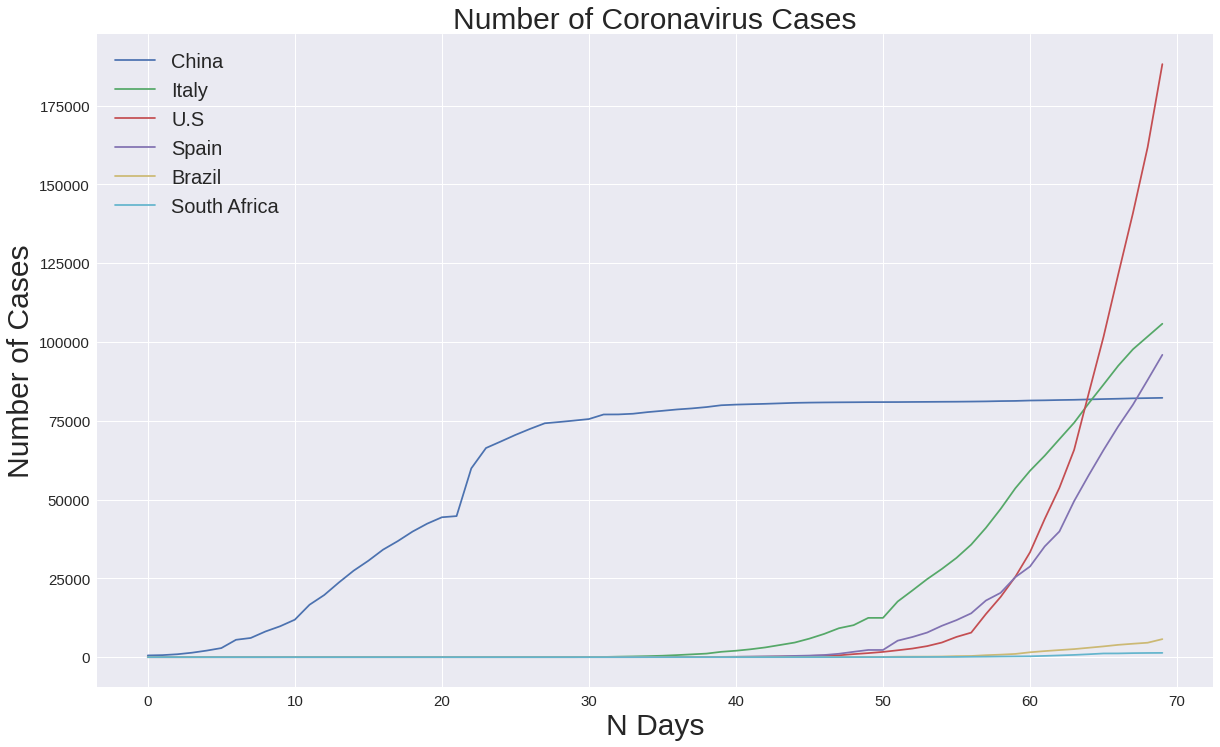

In [97]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, ch_cases.sum())
plt.plot(adjusted_dates, it_cases.sum())
plt.plot(adjusted_dates, us_cases.sum())
plt.plot(adjusted_dates, es_cases.sum())
plt.plot(adjusted_dates, br_cases.sum())
plt.plot(adjusted_dates, sa_cases.sum())
plt.title('Number of Coronavirus Cases', size=30)
plt.xlabel('N Days', size=30)
plt.ylabel('Number of Cases', size=30)
plt.legend(['China', 'Italy', 'U.S', 'Spain', 'Brazil', 'South Africa'], prop={'size': 20})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [0]:
from sklearn.model_selection import train_test_split , RandomizedSearchCV
confirmed_X_train, confirmed_X_test, confirmed_y_train, confirmed_y_test = train_test_split(days_1_22, world_cases, test_size=0.18)

### SVR

In [0]:
from sklearn.svm import SVR

In [0]:
# c = [0.01, 0.1, 1]
# gamma = [0.01, 0.1, 1]
# epsilon = [0.01, 0.1, 1]
# shrinking = [True, False]
# degree = [3, 4, 5, 6, 7]

# svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}

# svm = SVR(kernel='poly')
# svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
# svm_search.fit(X_train_confirmed, y_train_confirmed)

In [0]:
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=5, C=0.1)
svm_confirmed.fit(confirmed_X_train, confirmed_y_train)
svm_pred = svm_confirmed.predict(future)

MAE: 36648.01344121049
MSE: 1803086115.3986177


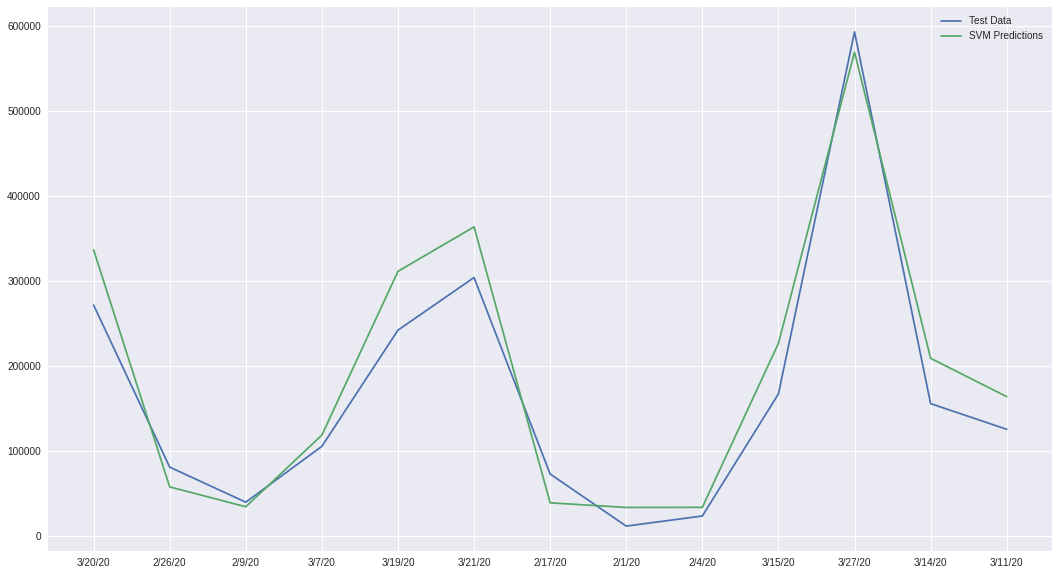

In [101]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
svm_test_pred = svm_confirmed.predict(confirmed_X_test)
plt.figure(figsize=(18,10))
plt.plot(confirmed_y_test)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, confirmed_y_test))
print('MSE:',mean_squared_error(svm_test_pred, confirmed_y_test))

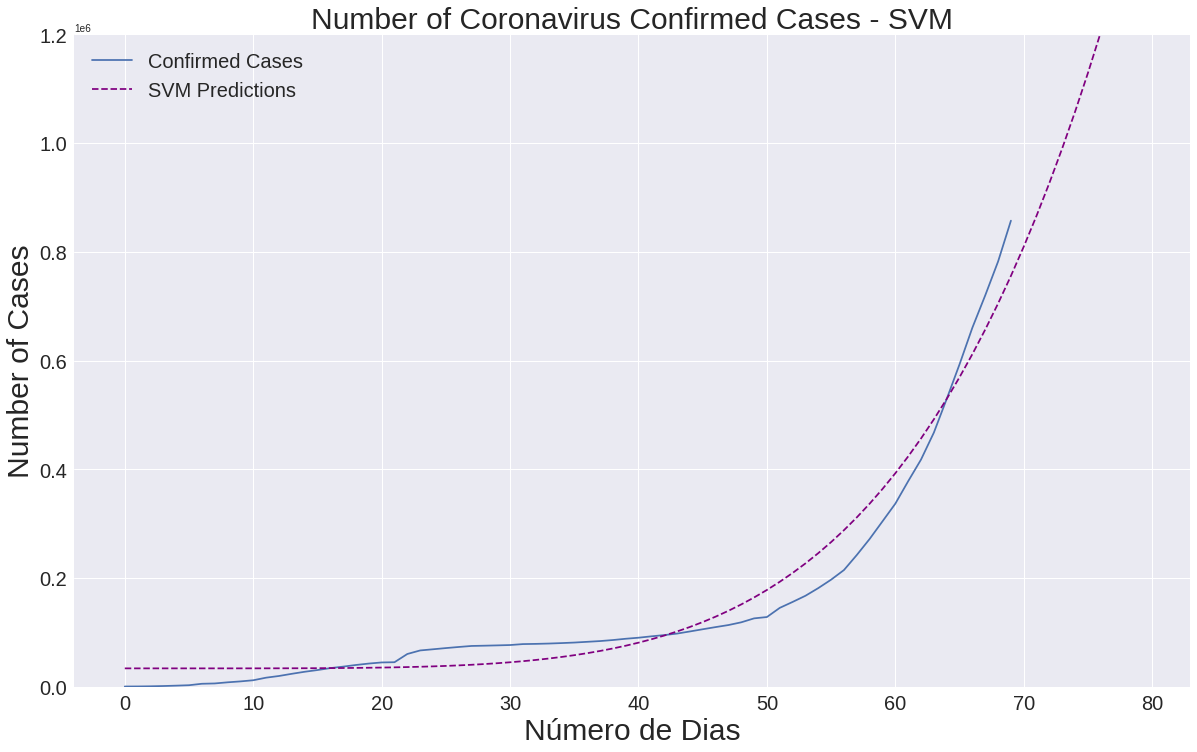

In [102]:
plt.figure(figsize=(20, 12))
ax = plt.gca()
plt.plot(adjusted_dates, world_cases)
plt.plot(future, svm_pred, linestyle='dashed', color='purple')
plt.title('Number of Coronavirus Confirmed Cases - SVM', size=30)
plt.xlabel('Número de Dias', size=30)
plt.ylim(0,1200000)
#plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0), useOffset=False)
plt.ylabel('Number of Cases', size=30)
plt.legend(['Confirmed Cases', 'SVM Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [103]:
# Future predictions using SVM 
print('SVM future predictions:')
set(zip(future_forcast_dates[-10:], np.round(svm_pred[-10:])))

SVM future predictions:


{('04/01/2020', 809788.0),
 ('04/02/2020', 866814.0),
 ('04/03/2020', 927145.0),
 ('04/04/2020', 990923.0),
 ('04/05/2020', 1058293.0),
 ('04/06/2020', 1129404.0),
 ('04/07/2020', 1204411.0),
 ('04/08/2020', 1283471.0),
 ('04/09/2020', 1366747.0),
 ('04/10/2020', 1454404.0)}

###Polynomial

In [0]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(confirmed_X_train)
poly_X_test_confirmed = poly.fit_transform(confirmed_X_test)
poly_future = poly.fit_transform(future)

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, confirmed_y_train)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future)

In [107]:
from sklearn.metrics import r2_score
R2_confirmed = r2_score(confirmed_y_test,test_linear_pred)
print(R2_confirmed)

0.9988985443894924


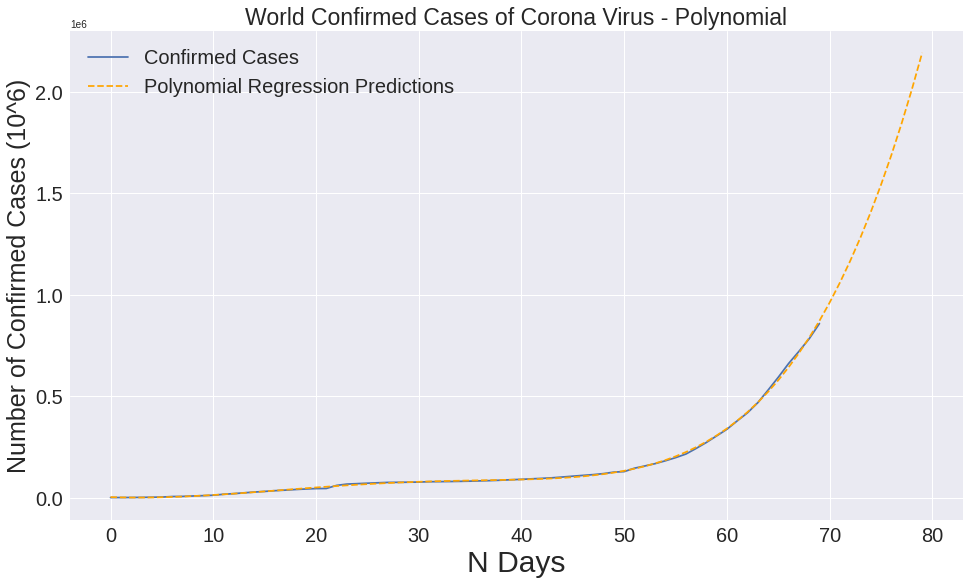

In [108]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.plot(future, linear_pred, linestyle='dashed', color='orange')
plt.title('World Confirmed Cases of Corona Virus - Polynomial', size=23)
plt.xlabel('N Days', size=30)
plt.ylabel('Number of Confirmed Cases (10^6)', size=25)
plt.legend(['Confirmed Cases', 'Polynomial Regression Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [109]:
linear_pred = linear_pred.reshape(1,-1)[0]
print('Polynomial regression future predictions:')
set(zip(future_forcast_dates[-10:], np.round(linear_pred[-10:])))

Polynomial regression future predictions:


{('04/01/2020', 961323.0),
 ('04/02/2020', 1059668.0),
 ('04/03/2020', 1166365.0),
 ('04/04/2020', 1281905.0),
 ('04/05/2020', 1406800.0),
 ('04/06/2020', 1541579.0),
 ('04/07/2020', 1686789.0),
 ('04/08/2020', 1842995.0),
 ('04/09/2020', 2010783.0),
 ('04/10/2020', 2190754.0)}

### Bayesian Ridge Regression

In [110]:
from sklearn.linear_model import BayesianRidge
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(fit_intercept=False, normalize=True)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(poly_X_train_confirmed, confirmed_y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.6s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=False,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=True, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                 

In [0]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(poly_future)

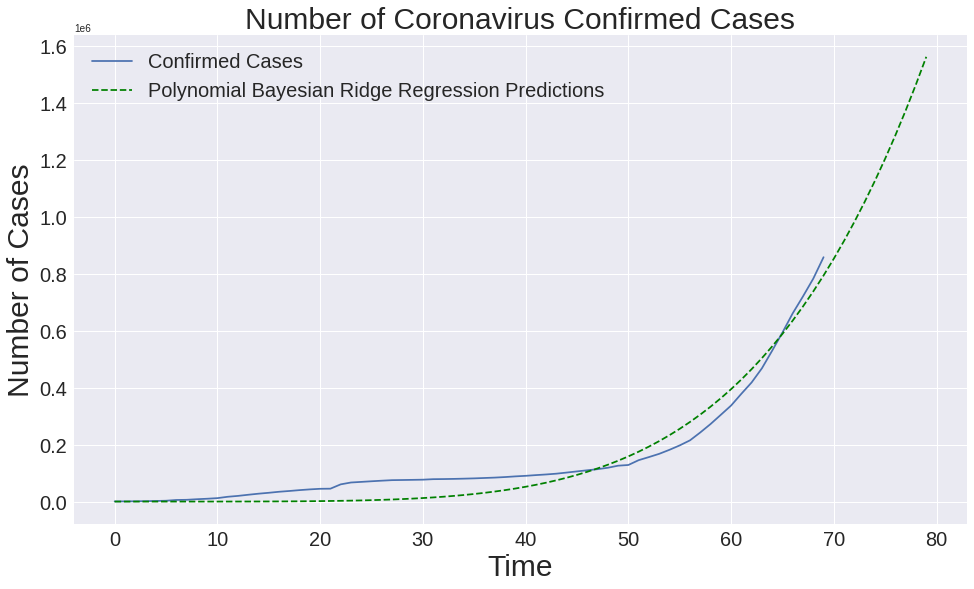

In [112]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.plot(future, bayesian_pred, linestyle='dashed', color='green')
plt.title('Number of Coronavirus Confirmed Cases', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('Number of Cases', size=30)
plt.legend(['Confirmed Cases', 'Polynomial Bayesian Ridge Regression Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [113]:
# Future predictions using Linear Regression 
print('Ridge regression future predictions:')
set(zip(future_forcast_dates[-10:], np.round(bayesian_pred[-10:])))

Ridge regression future predictions:


{('04/01/2020', 852483.0),
 ('04/02/2020', 915141.0),
 ('04/03/2020', 981429.0),
 ('04/04/2020', 1051505.0),
 ('04/05/2020', 1125527.0),
 ('04/06/2020', 1203661.0),
 ('04/07/2020', 1286074.0),
 ('04/08/2020', 1372942.0),
 ('04/09/2020', 1464441.0),
 ('04/10/2020', 1560755.0)}

## Predict Deaths

In [0]:
from sklearn.model_selection import train_test_split , RandomizedSearchCV
deaths_X_train, deaths_X_test, deaths_y_train, deaths_y_test = train_test_split(days_1_22, world_deaths, test_size=0.20)

In [0]:
from sklearn.svm import SVR

In [0]:
svm_deaths = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=5, C=0.1)
svm_deaths.fit(deaths_X_train, deaths_y_train)
svm_pred_deaths = svm_deaths.predict(future)

In [0]:
svm_test_pred_deaths = svm_deaths.predict(deaths_X_test)

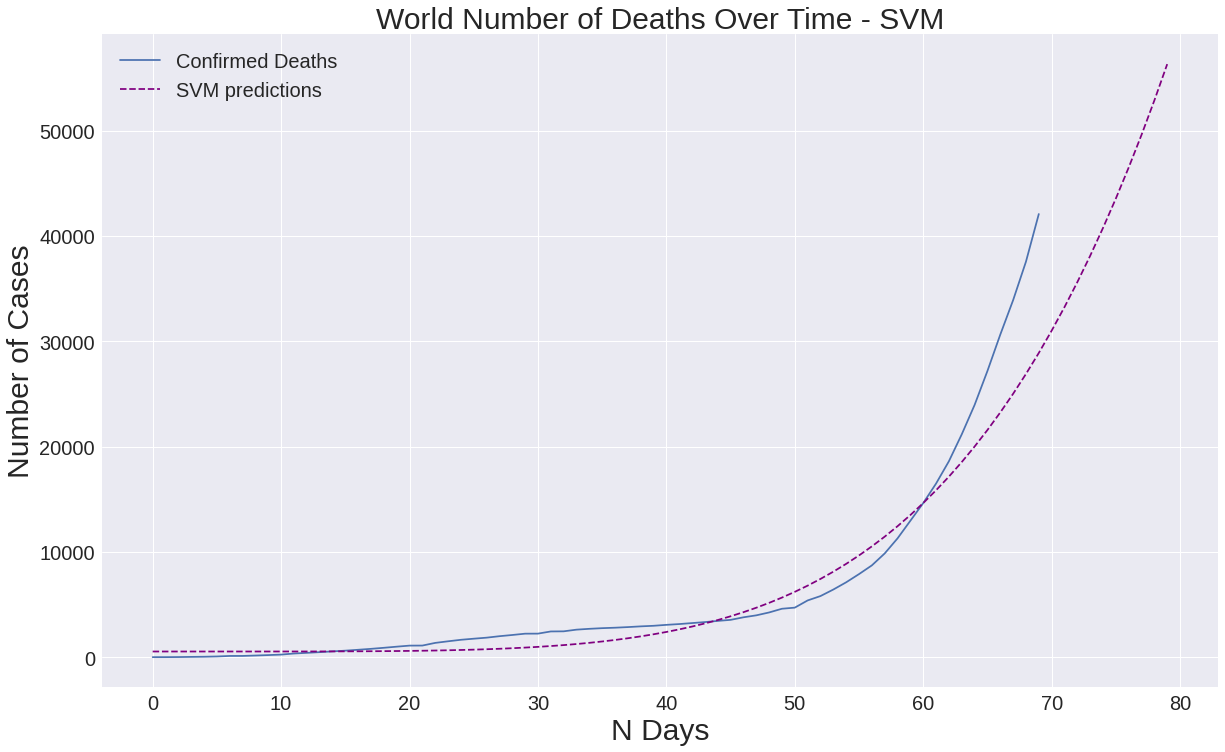

In [118]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_deaths)
plt.plot(future, svm_pred_deaths, linestyle='dashed', color='purple')
plt.title('World Number of Deaths Over Time - SVM', size=30)
plt.xlabel('N Days', size=30)
plt.ylabel('Number of Cases', size=30)
plt.legend(['Confirmed Deaths', 'SVM predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [119]:
# Future predictions using SVM 
print('SVM future predictions:')
set(zip(future_forcast_dates[-10:], np.round(svm_pred_deaths[-10:])))

SVM future predictions:


{('04/01/2020', 31027.0),
 ('04/02/2020', 33267.0),
 ('04/03/2020', 35636.0),
 ('04/04/2020', 38141.0),
 ('04/05/2020', 40787.0),
 ('04/06/2020', 43580.0),
 ('04/07/2020', 46526.0),
 ('04/08/2020', 49631.0),
 ('04/09/2020', 52902.0),
 ('04/10/2020', 56345.0)}

In [0]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=5)
poly_X_train_deaths = poly.fit_transform(deaths_X_train)
poly_X_test_deaths = poly.fit_transform(deaths_X_test)
poly_future = poly.fit_transform(future)

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
linear_model_deaths = LinearRegression(normalize=True, fit_intercept=False)
linear_model_deaths.fit(poly_X_train_deaths, deaths_y_train)
test_linear_pred_deaths = linear_model_deaths.predict(poly_X_test_deaths)
linear_pred_deaths = linear_model_deaths.predict(poly_future)

In [123]:
R2_deaths = r2_score(deaths_y_test,test_linear_pred_deaths)
print(R2_deaths)

0.9998051509130098


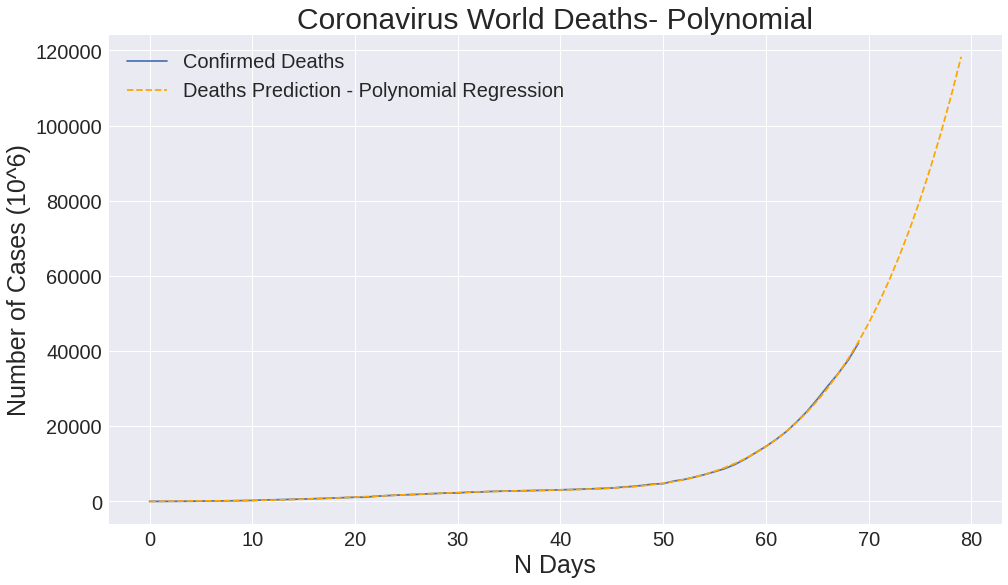

In [131]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_deaths)
plt.plot(future, linear_pred_deaths, linestyle='dashed', color='orange')
plt.title('Coronavirus World Deaths- Polynomial', size=30)
plt.xlabel('N Days', size=25)
plt.ylabel('Number of Cases (10^6)', size=25)
plt.legend(['Confirmed Deaths', 'Deaths Prediction - Polynomial Regression'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [125]:
linear_pred_deaths = linear_pred_deaths.reshape(1,-1)[0]
print('Polynomial regression future predictions:')
set(zip(future_forcast_dates[-10:], np.round(linear_pred_deaths[-10:])))

Polynomial regression future predictions:


{('04/01/2020', 47455.0),
 ('04/02/2020', 52915.0),
 ('04/03/2020', 58891.0),
 ('04/04/2020', 65420.0),
 ('04/05/2020', 72536.0),
 ('04/06/2020', 80277.0),
 ('04/07/2020', 88684.0),
 ('04/08/2020', 97797.0),
 ('04/09/2020', 107658.0),
 ('04/10/2020', 118312.0)}

## Predict Brazil

In [0]:
Brazil_deaths = deaths_df[deaths_df['Country/Region'] == 'Brazil'].drop(['Province/State','Country/Region','Lat','Long'],axis=1).sum()

In [0]:
from sklearn.model_selection import train_test_split , RandomizedSearchCV
deathsBR_X_train, deathsBR_X_test, deathsBR_y_train, deathsBR_y_test = train_test_split(days_1_22, Brazil_deaths, test_size=0.15)

In [0]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=5)
poly_X_train_deathsBR = poly.fit_transform(deathsBR_X_train)
poly_X_test_deathsBR = poly.fit_transform(deathsBR_X_test)
poly_future_BR = poly.fit_transform(future)

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
linear_model_deathsBR = LinearRegression(normalize=True, fit_intercept=False)
linear_model_deathsBR.fit(poly_X_train_deathsBR, deathsBR_y_train)
test_linear_pred_deathsBR = linear_model_deathsBR.predict(poly_X_test_deathsBR)
linear_pred_deathsBR = linear_model_deathsBR.predict(poly_future_BR)

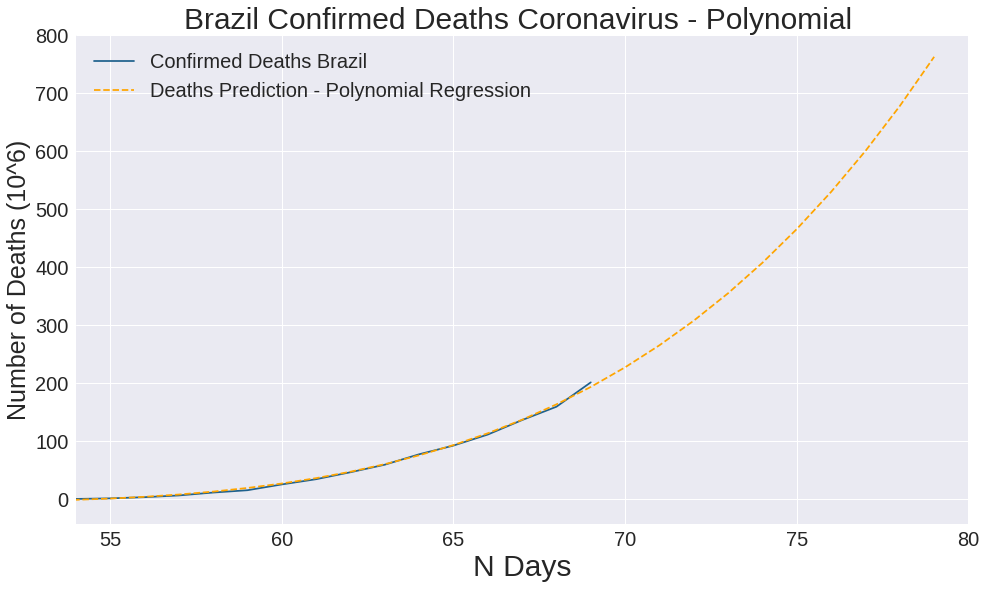

In [133]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, Brazil_deaths, color = '#1F618D')
plt.plot(future, linear_pred_deathsBR, linestyle='dashed', color='orange')
plt.title('Brazil Confirmed Deaths Coronavirus - Polynomial ', size=30)
plt.xlabel('N Days', size=30)
plt.ylabel('Number of Deaths (10^6)', size=25)
plt.xlim(54,80)
plt.legend(['Confirmed Deaths Brazil', 'Deaths Prediction - Polynomial Regression'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [54]:
linear_pred_deaths = linear_pred_deathsBR.reshape(1,-1)[0]
print('Polynomial regression future predictions:')
set(zip(future_forcast_dates[-10:], np.round(linear_pred_deathsBR[-10:])))

Polynomial regression future predictions:


{('04/01/2020', 219.0),
 ('04/02/2020', 255.0),
 ('04/03/2020', 295.0),
 ('04/04/2020', 340.0),
 ('04/05/2020', 389.0),
 ('04/06/2020', 444.0),
 ('04/07/2020', 504.0),
 ('04/08/2020', 570.0),
 ('04/09/2020', 643.0),
 ('04/10/2020', 722.0)}

## IT x BR x ES

In [0]:
Italy_deaths = deaths_df[deaths_df['Country/Region'] == 'Italy'].drop(['Province/State','Country/Region','Lat','Long'],axis=1).sum()

In [0]:
Spain_deaths = deaths_df[deaths_df['Country/Region'] == 'Spain'].drop(['Province/State','Country/Region','Lat','Long'],axis=1).sum()

In [0]:
itDaysFirstD = np.array([k+1 for k in range(len(Italy_deaths[Italy_deaths >= 1]))])
brDaysFirstD = np.array([k+1 for k in range(len(Brazil_deaths[Brazil_deaths >= 1]))])
esDaysFirstD = np.array([k+1 for k in range(len(Spain_deaths[Spain_deaths >= 1]))])

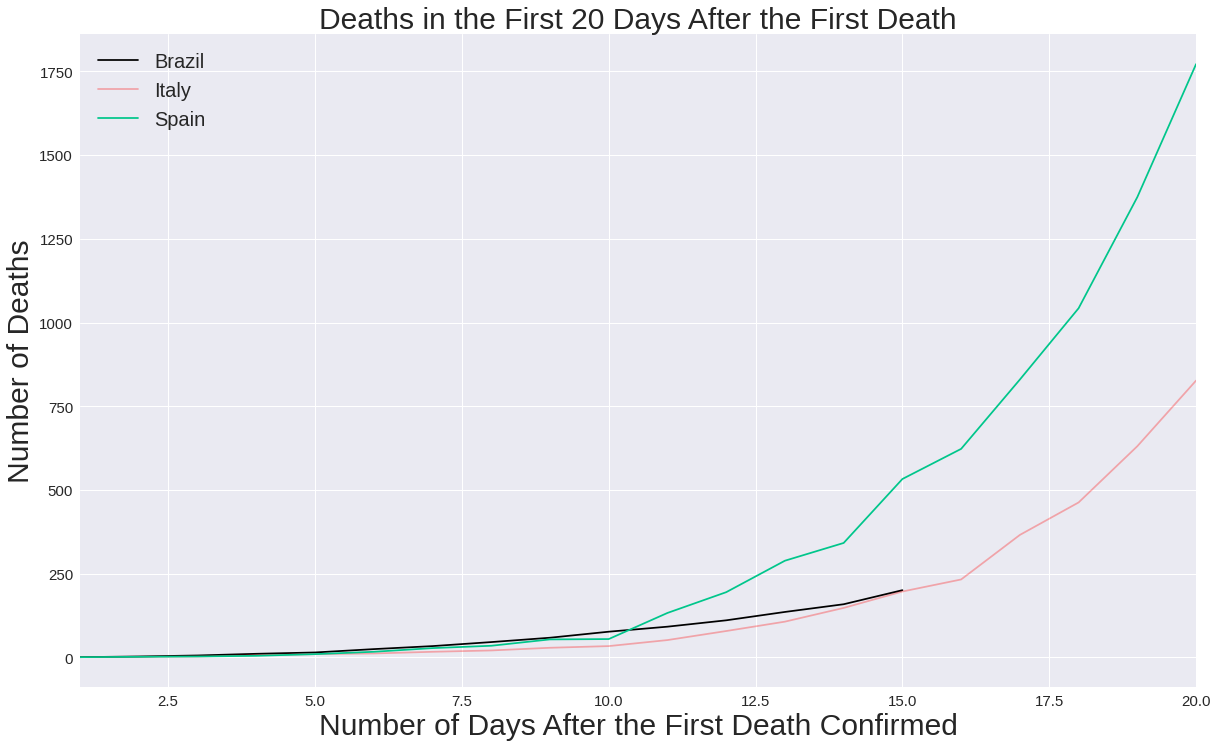

In [137]:
plt.figure(figsize=(20, 12))
plt.plot(brDaysFirstD, Brazil_deaths[Brazil_deaths >= 1], color="black")
plt.plot(itDaysFirstD[:20], Italy_deaths[Italy_deaths >= 1].head(20), color="red", alpha=0.3)
plt.plot(esDaysFirstD[:20], Spain_deaths[Spain_deaths >= 1].head(20), color = '#00c68b')
plt.xlim(1,20)
plt.title('Deaths in the First 20 Days After the First Death', size=30)
plt.xlabel('Number of Days After the First Death Confirmed', size=30)
plt.ylabel('Number of Deaths', size=30)
plt.legend(['Brazil', 'Italy', 'Spain'], prop={'size': 20}, loc='upper left')
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()